In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.fitting as fitting
import src.multielec_utils as mutils
from scipy.io import savemat, loadmat
import multiprocessing as mp

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
GSORT_BASE = "/Volumes/Scratch/Users/bhofflic/gsort"
ANALYSIS_BASE = "/Volumes/Scratch/Users/bhofflic/Preprocessed"
dataset = "2022-11-04-2"
wnoise = "data003"
blanked_probs = 12

estim_neg = "data004"

outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim_neg)
parameters = loadmat(os.path.join(outpath, 'parameters.mat'))

cells = parameters['cells'].flatten()
num_cells = len(cells)
num_patterns = max(parameters['patterns'].flatten())
num_movies = parameters['movies'].flatten()[0]

all_probs_neg = np.array(np.memmap(os.path.join(outpath, 'init_probs.dat'),mode='r',shape=(num_cells, num_patterns, num_movies), dtype='float32'))
trials_neg = np.array(np.memmap(os.path.join(outpath, 'trial.dat'),mode='r',shape=(num_patterns, num_movies), dtype='int16'), dtype=int)
amps_neg = np.array([mutils.get_stim_amps_newlv(electrical_path, 1).reshape(-1, 1)] * len(trials_neg))

# Processing data below: do other stuff if your pipeline is different
all_probs_neg[:, :, :blanked_probs] = np.zeros(all_probs_neg[:, :, :blanked_probs].shape)

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        all_probs_neg[i][j] = fitting.disambiguate_sigmoid(all_probs_neg[i][j], spont_limit=0.2, noise_limit=0.1)

In [3]:
ms = [1]

w_inits_array = np.zeros((all_probs_neg.shape[0], all_probs_neg.shape[1]), dtype=object)
for i in range(len(w_inits_array)):
    for j in range(len(w_inits_array[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_neg[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array[i][j] = w_inits

In [4]:
input_list = fitting.generate_input_list(all_probs_neg, amps_neg, trials_neg, w_inits_array)

pool = mp.Pool(processes=24)
results = pool.starmap_async(fitting.fit_surface, input_list)
mp_output = results.get()
pool.close()

In [5]:
mp_output_array = np.array(mp_output, dtype=object)
params_true = mp_output_array[:, 0].reshape(all_probs_neg.shape[0], all_probs_neg.shape[1])
probs_true_tmp = mp_output_array[:, 1].reshape(all_probs_neg.shape[0], all_probs_neg.shape[1])
inits = mp_output_array[:, 2].reshape(all_probs_neg.shape[0], all_probs_neg.shape[1])

probs_true = np.zeros(all_probs_neg.shape)
for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        probs_true[i][j] = probs_true_tmp[i][j]

[[-8.6831871  -4.21957586]]


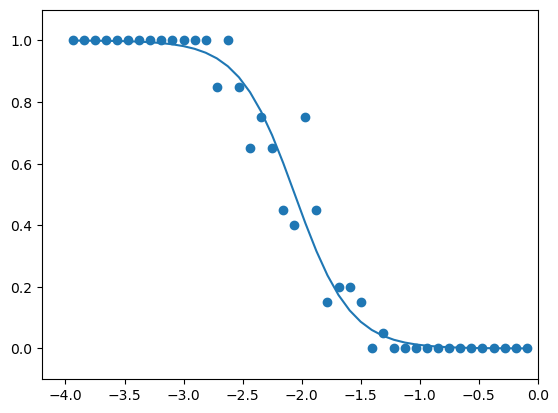

[[-10.95182745  -2.41952465]]


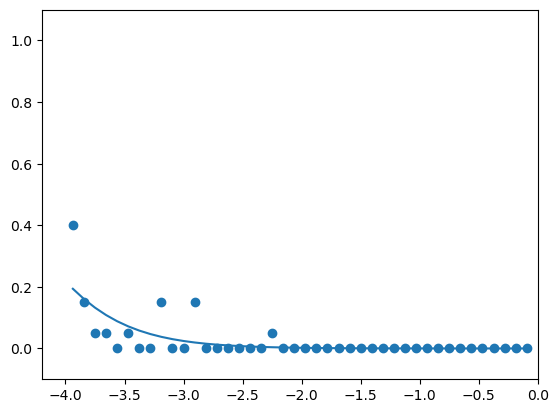

[[-12.62488052  -3.83223742]]


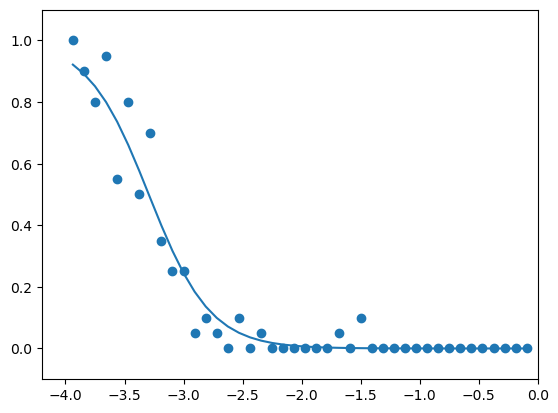

[[-17.84283256  -5.33662027]]


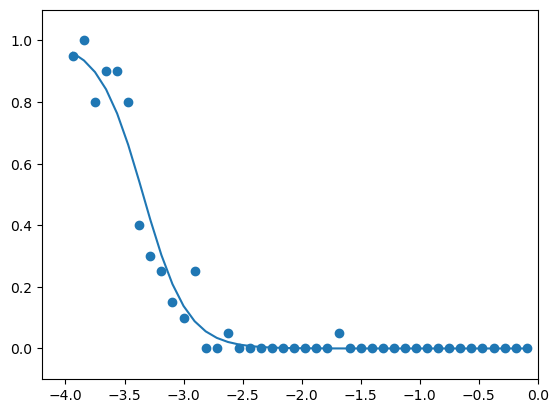

[[-8.38396653 -1.89883357]]


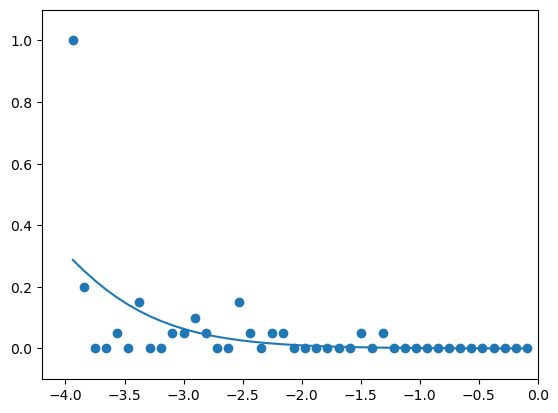

[[-9.52723091 -2.24393921]]


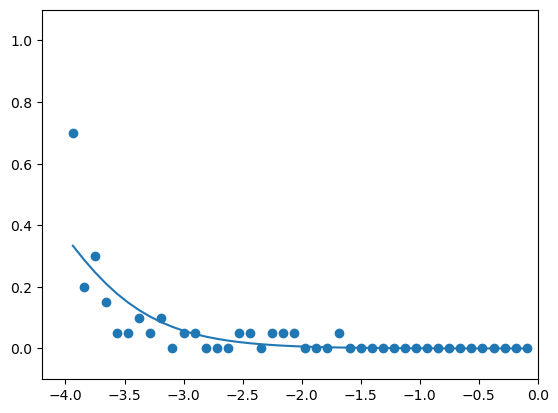

[[-10.16699155  -3.14797565]]


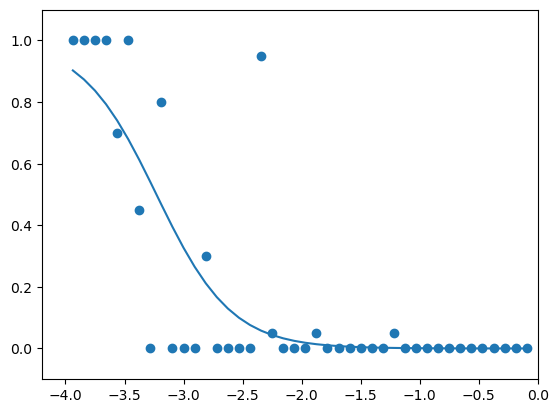

[[-32.53876471  -9.88751351]]


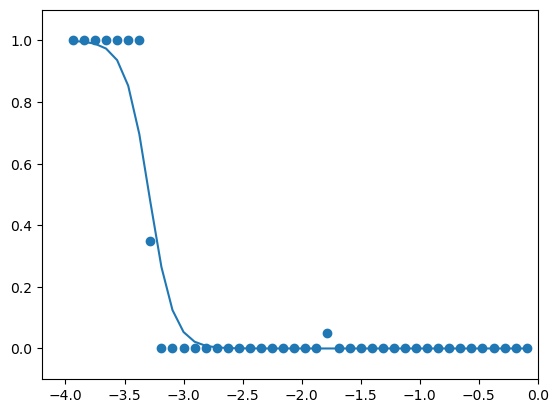

[[-36.60421753  -9.96115583]]


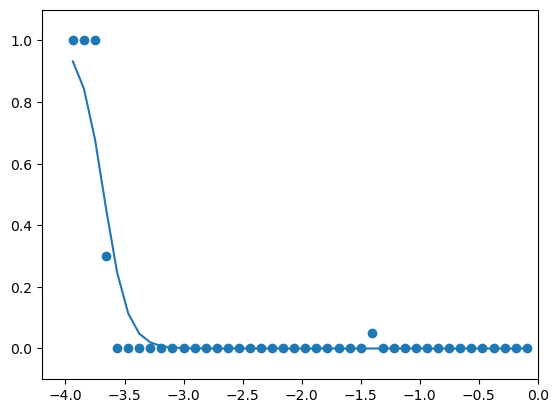

[[-17.34374995 -10.        ]]


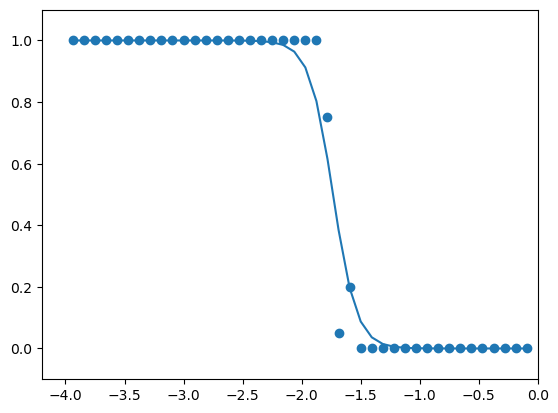

[[-23.9853516   -9.58216291]]


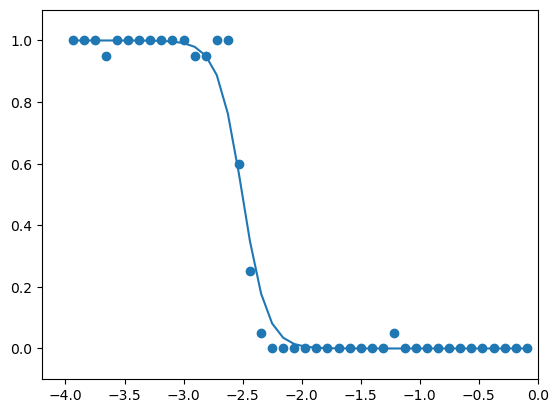

[[-16.73437492 -10.        ]]


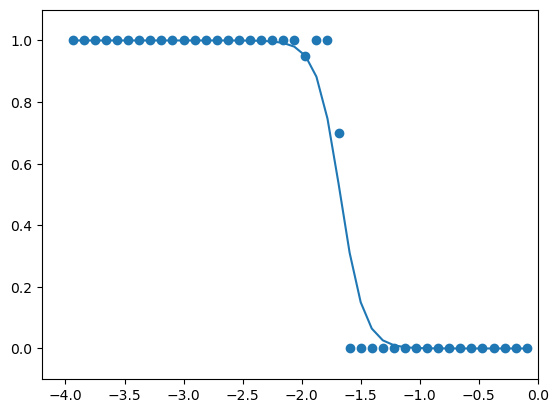

[[-24.84375029 -10.        ]]


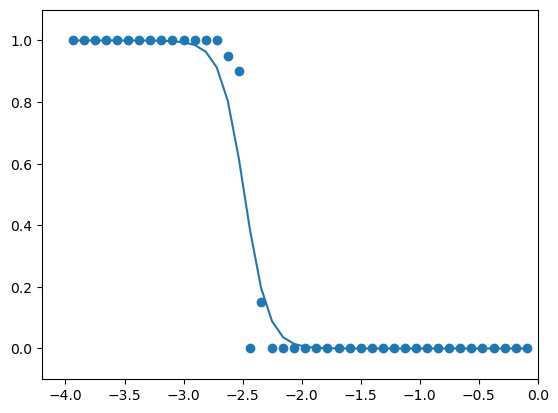

[[-21.56250001 -10.        ]]


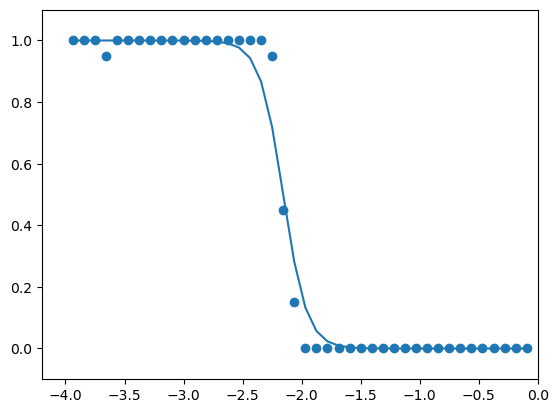

KeyboardInterrupt: Interrupted by user

In [6]:
# CHECK DATASET IF NEEDED

for i in range(len(all_probs_neg)):
    for j in range(len(all_probs_neg[i])):
        if ~np.all(params_true[i][j][:, 0] == -np.inf):

            print(params_true[i][j])
            
            plt.figure(0)
            plt.xlim(-4.2, 0,1)
            plt.ylim(-0.1, 1.1)
            plt.scatter(amps_neg[j].flatten(), all_probs_neg[i][j])
            plt.plot(amps_neg[j].flatten(), probs_true[i][j])
            plt.show()
            input()